# DRILL: Improve the gradient boost model

Improve the gradient boost model. Our goal is to predict whether the respondent lives with their significant other, by using all the other variables in the European Social Survey dataset. Let's see how low we can get the error rates to go in the test set, based on our model in the training set.  Strategies we will use include:

* Creating new features
* Applying more overfitting-prevention strategies like subsampling
* More iterations
* Trying a different loss function
* Changing the structure of the weak learner: Allowing more leaves in the tree, or other modifications

Have fun!

In [55]:
# Import libraries
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import ensemble
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier

from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [103]:
df = pd.read_csv((
    "https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/"
    "master/ESS_practice_data/ESSdata_Thinkful.csv")).dropna()
df.reset_index(drop = True, inplace=True)

# Definine outcome and predictors.
# Set our outcome to 0 and 1.
df['partner'] = df['partner'] - 1
y = df['partner']
X = df.loc[:, ~df.columns.isin(['partner', 'cntry', 'idno'])]

# Make the categorical variable 'country' into dummies.
X = pd.concat([X, pd.get_dummies(df['cntry'])], axis=1)

# Create training and test sets.
offset = int(X.shape[0] * 0.9)

# Put 90% of the data in the training set.
X_train, y_train = X[:offset], y[:offset]

# And put 10% in the test set.
X_test, y_test = X[offset:], y[offset:]

In [104]:
X_train.head()

,year,tvtot,ppltrst,pplfair,pplhlp,happy,sclmeet,sclact,gndr,agea,CH,CZ,DE,ES,NO,SE
0,6,3.0,3.0,10.0,5.0,8.0,5.0,4.0,2.0,60.0,1,0,0,0,0,0
1,6,6.0,5.0,7.0,5.0,9.0,3.0,2.0,2.0,59.0,1,0,0,0,0,0
2,6,1.0,8.0,8.0,8.0,7.0,6.0,3.0,1.0,24.0,1,0,0,0,0,0
3,6,4.0,6.0,6.0,7.0,10.0,6.0,2.0,2.0,64.0,1,0,0,0,0,0
4,6,5.0,6.0,7.0,5.0,8.0,7.0,2.0,2.0,55.0,1,0,0,0,0,0


## Improve Score via Boosting

In [105]:
# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))


Training set accuracy:
Percent Type I errors: 0.04650845608292417
Percent Type II errors: 0.17607746863066012

Test set accuracy:
Percent Type I errors: 0.06257668711656442
Percent Type II errors: 0.18527607361963191


## Current Accuracy Score

In [106]:
clf.score(X_test, y_test)

0.7521472392638037

## Current Confusion Matrix

In [107]:
#Create Confusion Matrix (outlines Type 1 and 2 Errors)
y_pred = clf.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[454,  51],
       [151, 159]], dtype=int64)

## Determine Important Features

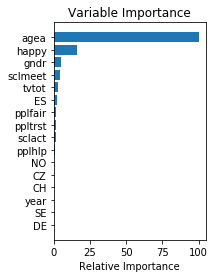

In [108]:
feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

As this plot shows, age and happiness are the two most significant features in determining if the responder lives with a significant other. We currently have an accuracy score of 75.2%, but let's see if we can improve the predictions with some new features.

## Remove Least-Important Features

In [112]:
X = X.drop(list(X.columns[sorted_idx][:6]), axis=1)

## Create New Features

In [113]:
#Combine ppl features into new interaction feature
X['ppl_interaction'] = X['ppltrst'] * X['pplfair'] *X['pplhlp']

In [114]:
#Combine scl features into new interaction feature
X['scl_interaction'] = X['sclact']*X['sclmeet']

In [115]:
#Normalize all features using min-max scaling, so that they have the same range: [0,1]
norm_df = pd.DataFrame()
for cat in list(X.columns):
    normed = []
    for i in range(len(X[cat])):
        xmax = X[cat].max()
        xmin = X[cat].min()
        normed.append((X[cat][i]-xmin)/(xmax-xmin))

    norm_df[cat] = normed
    
norm_df.head()

,tvtot,ppltrst,pplfair,pplhlp,happy,sclmeet,sclact,gndr,agea,ES,ppl_interaction,scl_interaction
0,0.428571,0.3,1.0,0.5,0.8,0.666667,0.75,1.0,0.454545,0.0,0.150,0.558824
1,0.857143,0.5,0.7,0.5,0.9,0.333333,0.25,1.0,0.444444,0.0,0.175,0.147059
2,0.142857,0.8,0.8,0.8,0.7,0.833333,0.50,0.0,0.090909,0.0,0.512,0.500000
3,0.571429,0.6,0.6,0.7,1.0,0.833333,0.25,1.0,0.494949,0.0,0.252,0.323529
4,0.714286,0.6,0.7,0.5,0.8,1.000000,0.25,1.0,0.404040,0.0,0.210,0.382353


## Analyze Feature Correlations

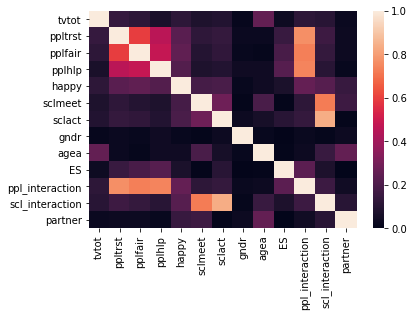

In [116]:
import seaborn as sns
norm_df['partner'] = df['partner']
plt.figure()
sns.heatmap(abs(norm_df.corr()))
plt.show()

As expected, the interaction features have high correlation with their component features, so we need to drop the components, as they are extraneous to our model. Surprisingly, though, most of the features seem to have low correlation to 'partner', which may be problematic.

In [117]:
#Drop those extraneous columns
norm_df = norm_df.drop(['sclmeet','sclact','ppltrst','pplfair','pplhlp'], axis=1)

## Model Several Classifiers to Vote

In [118]:
y2 = norm_df['partner']
X2 = norm_df.drop(['partner'], axis=1)

#Prepare train-test split
offset2 = int(X2.shape[0] * 0.9)

# Put 90% of the data in the training set.
X2_train, y2_train = X2[:offset2], y2[:offset2]

# And put 10% in the test set.
X2_test, y2_test = X2[offset2:], y2[offset2:]

In [119]:
#Model classifers for voting
lr = LogisticRegression()
rf = RandomForestClassifier(n_estimators=2000)
gb = GradientBoostingClassifier()
gnb = GaussianNB()
brb = BernoulliNB()
knn = KNeighborsClassifier(n_neighbors=7)
dtc = DecisionTreeClassifier(max_depth=4)

In [120]:
#Voting Classifer 
vc = VotingClassifier(estimators=[('lr', lr), ('rf', rf),('gb',gb) ,('knn',knn),('dtc', dtc)], voting='hard')
vc.fit(X2_train, y2_train)
vc_score = vc.score(X2_test, y2_test)

print('Voting Classifier Score: ', vc_score)

Voting Classifier Score:  0.7361963190184049


## Cross-Validation

In [121]:
#10-fold model validation
from sklearn.model_selection import cross_val_score
cross_score = cross_val_score(vc, X2_test, y2_test, cv=10)

print(cross_score)
print('Average Cross-Validation Score: ', cross_score.mean())

[0.62195122 0.59756098 0.6097561  0.57317073 0.53658537 0.58024691
 0.65432099 0.72839506 0.45679012 0.37037037]
Average Cross-Validation Score:  0.5729147847034025


Although the initial run of the Voting Classifier showed approximately the same accuracy as the original model, cross-validation showed that each fold had wildly varying accuracy values, for an average accuracy of 58%, which is significantly lower than the original accuracy. Let's try something else to improve accuracy.

## Boosting

In [122]:
# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance'}

# Initialize and fit the model.
clf2 = ensemble.GradientBoostingClassifier(**params)
clf2.fit(X2_train, y2_train)

predict2_train = clf2.predict(X2_train)
predict2_test = clf2.predict(X2_test)

# Accuracy tables.
table2_train = pd.crosstab(y2_train, predict2_train, margins=True)
table2_test = pd.crosstab(y2_test, predict2_test, margins=True)

train2_tI_errors = table2_train.loc[0.0,1.0] / table2_train.loc['All','All']
train2_tII_errors = table2_train.loc[1.0,0.0] / table2_train.loc['All','All']

test2_tI_errors = table2_test.loc[0.0,1.0]/table2_test.loc['All','All']
test2_tII_errors = table2_test.loc[1.0,0.0]/table2_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train2_tI_errors, train2_tII_errors, test2_tI_errors, test2_tII_errors))


Training set accuracy:
Percent Type I errors: 0.045553737043098744
Percent Type II errors: 0.17907801418439717

Test set accuracy:
Percent Type I errors: 0.05276073619631902
Percent Type II errors: 0.2098159509202454


In [123]:
clf2.score(X2_test, y2_test)

0.7374233128834355

## New Confusion Matrix

In [124]:
#Create Confusion Matrix (outlines Type 1 and 2 Errors)
y2_pred = clf2.predict(X2_test)
confusion_matrix(y2_test, y2_pred)

array([[462,  43],
       [171, 139]], dtype=int64)

## Reduce Number of Features

In [137]:
fin_df = norm_df[list(abs(norm_df.corr())['partner'].sort_values(ascending = False)[:5].index)]

## Model Several Classifiers to Vote

In [138]:
y3 = fin_df['partner']
X3 = fin_df.drop(['partner'], axis=1)

#Prepare train-test split
offset3 = int(X3.shape[0] * 0.9)

# Put 90% of the data in the training set.
X3_train, y3_train = X3[:offset3], y3[:offset3]

# And put 10% in the test set.
X3_test, y3_test = X3[offset3:], y3[offset3:]

In [139]:
#Model classifers for voting
lr = LogisticRegression()
rf = RandomForestClassifier(n_estimators=2000)
gb = GradientBoostingClassifier()
gnb = GaussianNB()
brb = BernoulliNB()
knn = KNeighborsClassifier(n_neighbors=7)
dtc = DecisionTreeClassifier(max_depth=4)

In [140]:
#Voting Classifer 
vc = VotingClassifier(estimators=[('lr', lr), ('rf', rf),('gb',gb) ,('knn',knn),('dtc', dtc)], voting='hard')
vc.fit(X3_train, y3_train)
vc_score = vc.score(X3_test, y3_test)

print('Voting Classifier Score: ', vc_score)

Voting Classifier Score:  0.7337423312883435


## Cross-Validation

In [141]:
#10-fold model validation
from sklearn.model_selection import cross_val_score
cross_score = cross_val_score(vc, X3_test, y3_test, cv=10)

print(cross_score)
print('Average Cross-Validation Score: ', cross_score.mean())

[0.62195122 0.6097561  0.58536585 0.52439024 0.5        0.50617284
 0.59259259 0.66666667 0.41975309 0.37037037]
Average Cross-Validation Score:  0.5397018970189702


## Boosting

In [142]:
# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance'}

# Initialize and fit the model.
clf3 = ensemble.GradientBoostingClassifier(**params)
clf3.fit(X3_train, y3_train)

predict3_train = clf3.predict(X3_train)
predict3_test = clf3.predict(X3_test)

# Accuracy tables.
table3_train = pd.crosstab(y3_train, predict3_train, margins=True)
table3_test = pd.crosstab(y3_test, predict3_test, margins=True)

train3_tI_errors = table3_train.loc[0.0,1.0] / table3_train.loc['All','All']
train3_tII_errors = table3_train.loc[1.0,0.0] / table3_train.loc['All','All']

test3_tI_errors = table3_test.loc[0.0,1.0]/table3_test.loc['All','All']
test3_tII_errors = table3_test.loc[1.0,0.0]/table3_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train3_tI_errors, train3_tII_errors, test3_tI_errors, test3_tII_errors))


Training set accuracy:
Percent Type I errors: 0.044189852700491
Percent Type II errors: 0.19353518821603927

Test set accuracy:
Percent Type I errors: 0.05521472392638037
Percent Type II errors: 0.2098159509202454


In [143]:
clf3.score(X3_test, y3_test)

0.7349693251533742

## New Confusion Matrix

In [144]:
#Create Confusion Matrix (outlines Type 1 and 2 Errors)
y3_pred = clf3.predict(X3_test)
confusion_matrix(y3_test, y3_pred)

array([[460,  45],
       [171, 139]], dtype=int64)

Based on all of the tests I ran, I don't think it is possible to improve the accuracy of this type of model past the 75% that we already had from the beginning.